In [66]:
import torch 
from torch.utils.data import DataLoader 
from tqdm import tqdm 
import numpy as np
from typing import List, Optional, Tuple
import sys 
sys.path.insert(0, "../")
from DEFAULTS import BASE_PATH 
from loaders import get_dataset 
from model_builder import get_pretrained_model_v2 

DATASET = "optim"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"
GLOBAL_POOL = "avg"


def get_classes(dataset: str):
    if dataset == "optim":
        return ["Actin", "Tubulin", "CaMKII", "PSD95"]  
    elif dataset == "neural-activity-states":
        return ["Block", "0Mg", "GluGly", "48hTTX"]
    elif dataset == "peroxisome":
        return ["6hGluc", "6hMeOH"]
    elif dataset == "polymer-rings":
        return ["CdvB1", "CdvB2"]
    elif dataset == "dl-sim":
        return ["adhesion", "factin", "microtubule", "mitosis"]
    else:
        raise ValueError(f"Dataset {dataset} not supported")
    
CLASSES = get_classes(DATASET)
N_CLASSES = len(CLASSES)


### Load Model

In [67]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Running on {DEVICE} ---")

model, cfg = get_pretrained_model_v2(
    name=MODEL,
    weights=WEIGHTS,
    path=None,
    mask_ratio=0.0,
    pretrained=True if "imagenet" in WEIGHTS.lower() else False,
    in_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
    as_classifier=True,
    blocks="all",
    num_classes=4
)
model.to(DEVICE)
model.eval()

--- Running on cuda ---
mask_ratio 0.0
pretrained False
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


### Load dataset

In [68]:
_, _, test_loader = get_dataset(
    name=DATASET,
    transform=None,
    training=True,
    path=None,
    batch_size=cfg.batch_size,
    n_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
)

/home-local/Frederic/evaluation-data/optim_train
Train dataset size: 1536 --> (array([0, 1, 2, 3]), array([881, 220, 208, 227]))
Valid dataset size: 147 --> (array([0, 1, 2, 3]), array([82, 29, 16, 20]))
Test dataset size: 438 --> (array([0, 1, 2, 3]), array([261,  60,  56,  61]))


### Embed dataset using model

In [69]:
embeddings, labels, dataset_idx = [], [], []
with torch.no_grad():
    for img, metadata in tqdm(test_loader):
        img = img.to(DEVICE)
        label = metadata["label"]
        d_id = metadata["dataset-idx"]
        output = model.forward_features(img)
        embeddings.extend(output.data.cpu().numpy())
        labels.extend(label)
        dataset_idx.extend(d_id)

embeddings = np.array(embeddings)
labels = np.array(labels)
dataset_idx = np.array(dataset_idx)
print(embeddings.shape, labels.shape)
assert embeddings.shape[0] == labels.shape[0]

100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

(438, 384) (438,)


(438, 384)


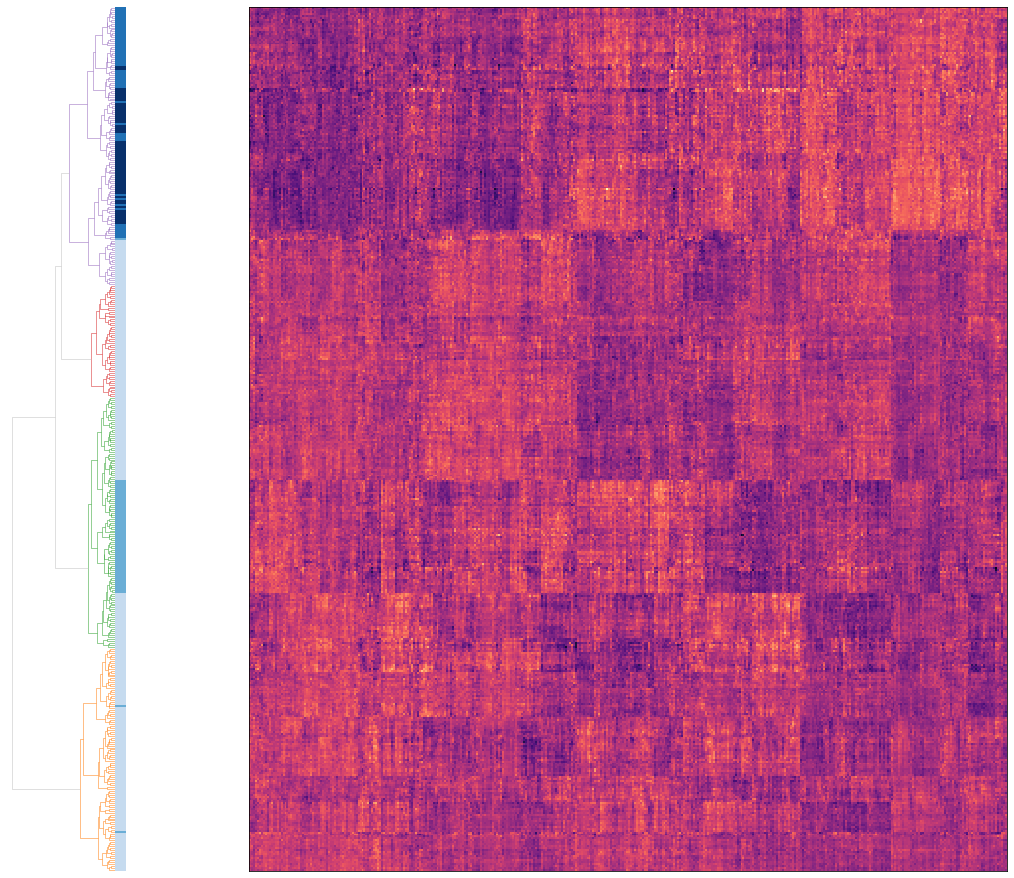

In [70]:
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib

if labels.dtype == np.float32:
    labels = labels.astype(np.int32)
uniques = np.unique(labels)
D = embeddings 
print(D.shape)
D = StandardScaler().fit_transform(D) 
Y1 = hierarchy.linkage(D, method="ward", metric="euclidean")
clusters1 = hierarchy.fcluster(Y1, N_CLASSES, criterion="maxclust")

# Find the distance threshold that gives the same clustering
distances = Y1[:, 2]  # The third column of the linkage matrix contains the distances
threshold = sorted(distances)[1-N_CLASSES]  # n_samples - n_clusters = -3 for 4 clusters d
Y2 = hierarchy.linkage(D.T, method="ward", metric="euclidean")

fig = plt.figure(figsize=(15, 15))
ax3 = fig.add_axes([0, 0, 0.1, 0.8])
ax3.set_xticks([])
ax3.set_yticks([])
fig.gca().invert_xaxis() 
ax3.axis("off")

zmap = plt.get_cmap("tab10", len(uniques))

Z1 = hierarchy.dendrogram(
    Y1, orientation="left",
    above_threshold_color="silver",
    ax=ax3,
    color_threshold=threshold
)
Z2 = hierarchy.dendrogram(
    Y2, orientation="right",
    above_threshold_color="silver",
    no_plot=True
)
for collection in ax3.collections:
    collection.set_linewidth(0.5)

ax4 = fig.add_axes([0.1,0,0.01, 0.8])
ax4.set_xticks([])
ax4.set_yticks([])
ax4.axis('off')

cmap = plt.get_cmap("Blues", len(set(uniques)) + 1)
all_colors = []
for i, leaf in enumerate(Z1["leaves"]):
    all_colors.append(cmap(labels[leaf] + 1))
    ax4.barh(i + 0.5, 1, 1.0, color=cmap(labels[leaf] + 1))
#     # ax4.axhline(i + 0.5, color=cmap(GROUPS_MODEL[groups[leaf]] + 1))
ax4.set(
    ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
)
ax4.invert_yaxis()
    

axmatrix2 = fig.add_axes([0.15,0,0.85, 0.8])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = D[idx1,:]
sorted_co_matrix = sorted_co_matrix[:, idx2]
im2 = axmatrix2.matshow(sorted_co_matrix, aspect='equal', origin='lower', cmap="magma")
axmatrix2.set_xticks([])
axmatrix2.set_yticks([])
fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis





### Quantitative Analysis of clustering tendency

1 [0, 0, 52, 61]
2 [122, 1, 4, 0]
3 [0, 57, 0, 0]
4 [139, 2, 0, 0]


<ipython-input-71-43c8595c5416>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(CLASSES, rotation=25)


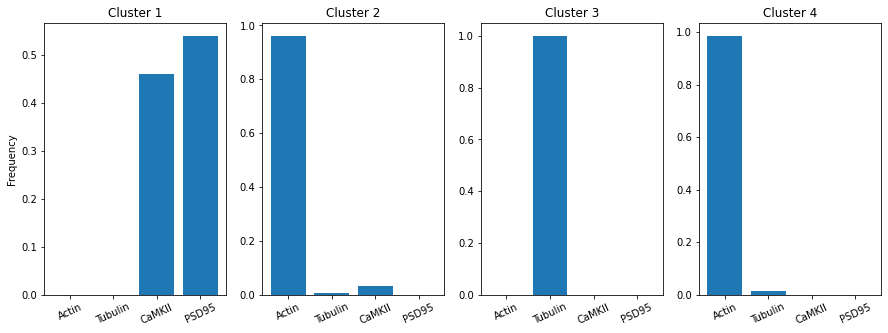

In [71]:
frequencies = {
    key: [0] * len(np.unique(labels)) for key in np.unique(clusters1)
}

uniques, counts = np.unique(labels, return_counts=True)
num_clusters = len(np.unique(clusters1))

for cluster_id, true_label in zip(clusters1, labels):
    frequencies[cluster_id][true_label] += 1

for key, value in frequencies.items():
    print(key, value)

fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    total = sum(frequencies[i+1])
    axs[i].bar(CLASSES, [item / total for item in frequencies[i+1]])
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].set_xticklabels(CLASSES, rotation=25)
    axs[0].set_ylabel("Frequency")
plt.show()



### Recursive clustering

In [72]:
c1_indices = np.where(clusters1 == 1)[0] 
c1_embeddings = []
labels_too = []
for i, idx in enumerate(c1_indices):
    d_idx = dataset_idx[idx]
    img = test_loader.dataset[d_idx][0]
    label = test_loader.dataset[d_idx][1]["label"]
    labels_too.append(label)
    img = img.unsqueeze(0).to(DEVICE)
    output = model.forward_features(img)
    c1_embeddings.extend(output.data.cpu().numpy())
c1_embeddings = np.array(c1_embeddings)
labels_too = np.array(labels_too)
print(c1_embeddings.shape)

(113, 384)


(113, 384)


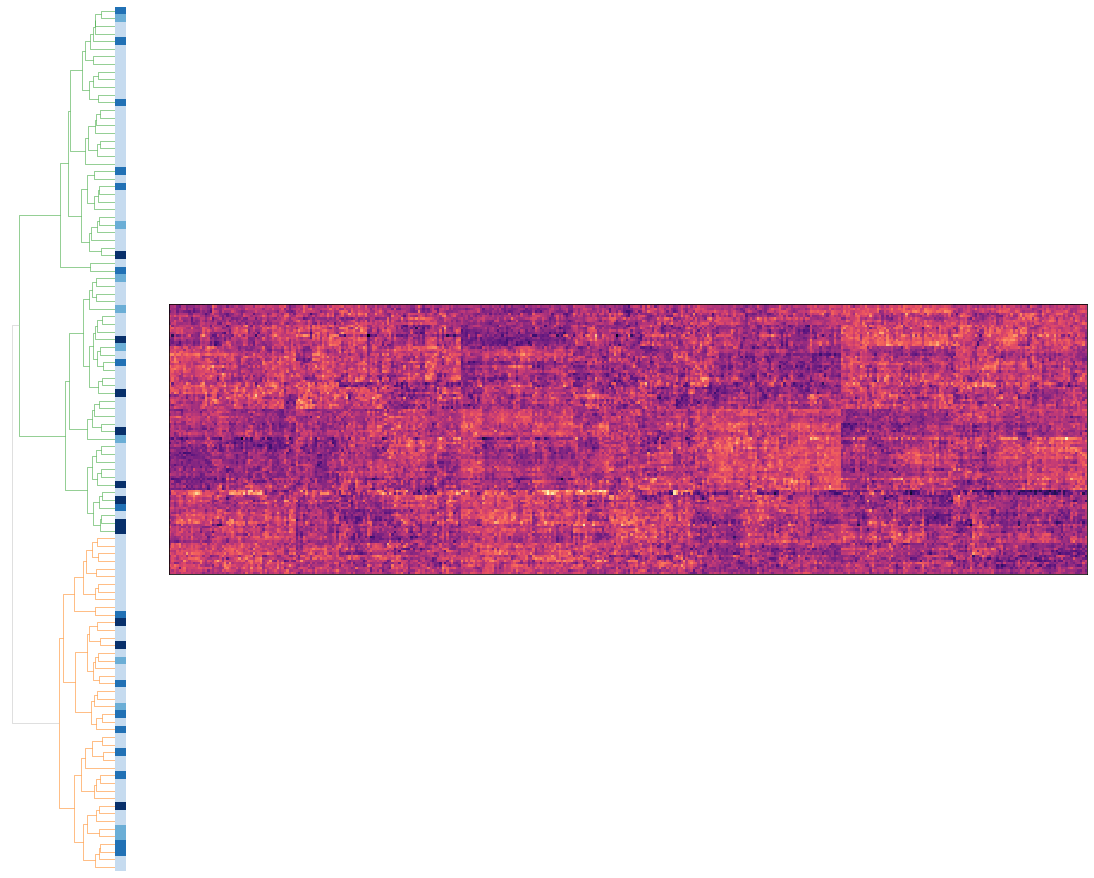

In [73]:

# if labels.dtype == np.float32:
#     labels = labels.astype(np.int32)
# uniques = np.unique(labels)
D = c1_embeddings 
print(D.shape)
D = StandardScaler().fit_transform(D) 
Y1 = hierarchy.linkage(D, method="ward", metric="euclidean")
clusters1_too = hierarchy.fcluster(Y1, 2, criterion="maxclust")

# Find the distance threshold that gives the same clustering
distances = Y1[:, 2]  # The third column of the linkage matrix contains the distances
threshold = sorted(distances)[1-2]  # n_samples - n_clusters = -3 for 4 clusters d
Y2 = hierarchy.linkage(D.T, method="ward", metric="euclidean")

fig = plt.figure(figsize=(15, 15))
ax3 = fig.add_axes([0, 0, 0.1, 0.8])
ax3.set_xticks([])
ax3.set_yticks([])
fig.gca().invert_xaxis() 
ax3.axis("off")

zmap = plt.get_cmap("tab10", len(uniques))

Z1 = hierarchy.dendrogram(
    Y1, orientation="left",
    above_threshold_color="silver",
    ax=ax3,
    color_threshold=threshold
)
Z2 = hierarchy.dendrogram(
    Y2, orientation="right",
    above_threshold_color="silver",
    no_plot=True
)
for collection in ax3.collections:
    collection.set_linewidth(0.5)

ax4 = fig.add_axes([0.1,0,0.01, 0.8])
ax4.set_xticks([])
ax4.set_yticks([])
ax4.axis('off')

cmap = plt.get_cmap("Blues", len(set(uniques)) + 1)
all_colors = []
for i, leaf in enumerate(Z1["leaves"]):
    all_colors.append(cmap(labels[leaf] + 1))
    ax4.barh(i + 0.5, 1, 1.0, color=cmap(labels[leaf] + 1))
#     # ax4.axhline(i + 0.5, color=cmap(GROUPS_MODEL[groups[leaf]] + 1))
ax4.set(
    ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
)
ax4.invert_yaxis()
    

axmatrix2 = fig.add_axes([0.15,0,0.85, 0.8])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = D[idx1,:]
sorted_co_matrix = sorted_co_matrix[:, idx2]
im2 = axmatrix2.matshow(sorted_co_matrix, aspect='equal', origin='lower', cmap="magma")
axmatrix2.set_xticks([])
axmatrix2.set_yticks([])
fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis


[2 3]
1 [42, 2]
2 [10, 59]


<ipython-input-76-27af0e41e427>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(["CaMKII", "PSD95"], rotation=25)


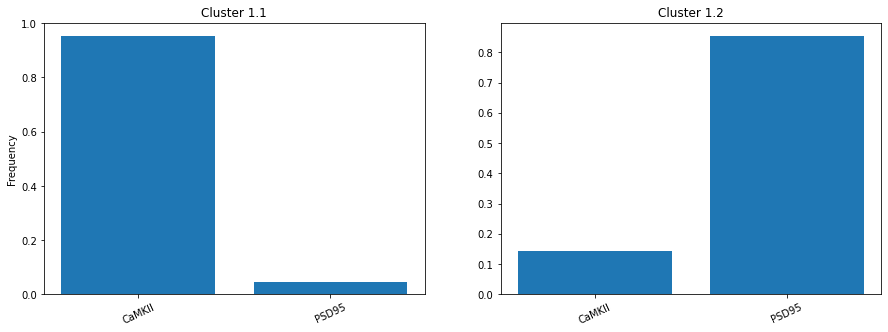

In [76]:
frequencies_too = {
    key: [0] * 2 for key in np.unique(clusters1_too)
}

num_clusters = len(np.unique(clusters1_too))
print(np.unique(labels_too))

for cluster_id, true_label in zip(clusters1_too, labels_too):
    frequencies_too[cluster_id][true_label - 2] += 1

for key, value in frequencies_too.items():
    print(key, value)

fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    total = sum(frequencies_too[i+1])
    axs[i].bar(["CaMKII", "PSD95"], [item / total for item in frequencies_too[i+1]])
    axs[i].set_title(f"Cluster 1.{i+1}")
    axs[i].set_xticklabels(["CaMKII", "PSD95"], rotation=25)
    axs[0].set_ylabel("Frequency")
plt.show()

### Exploratory code

[1 2 3 4]


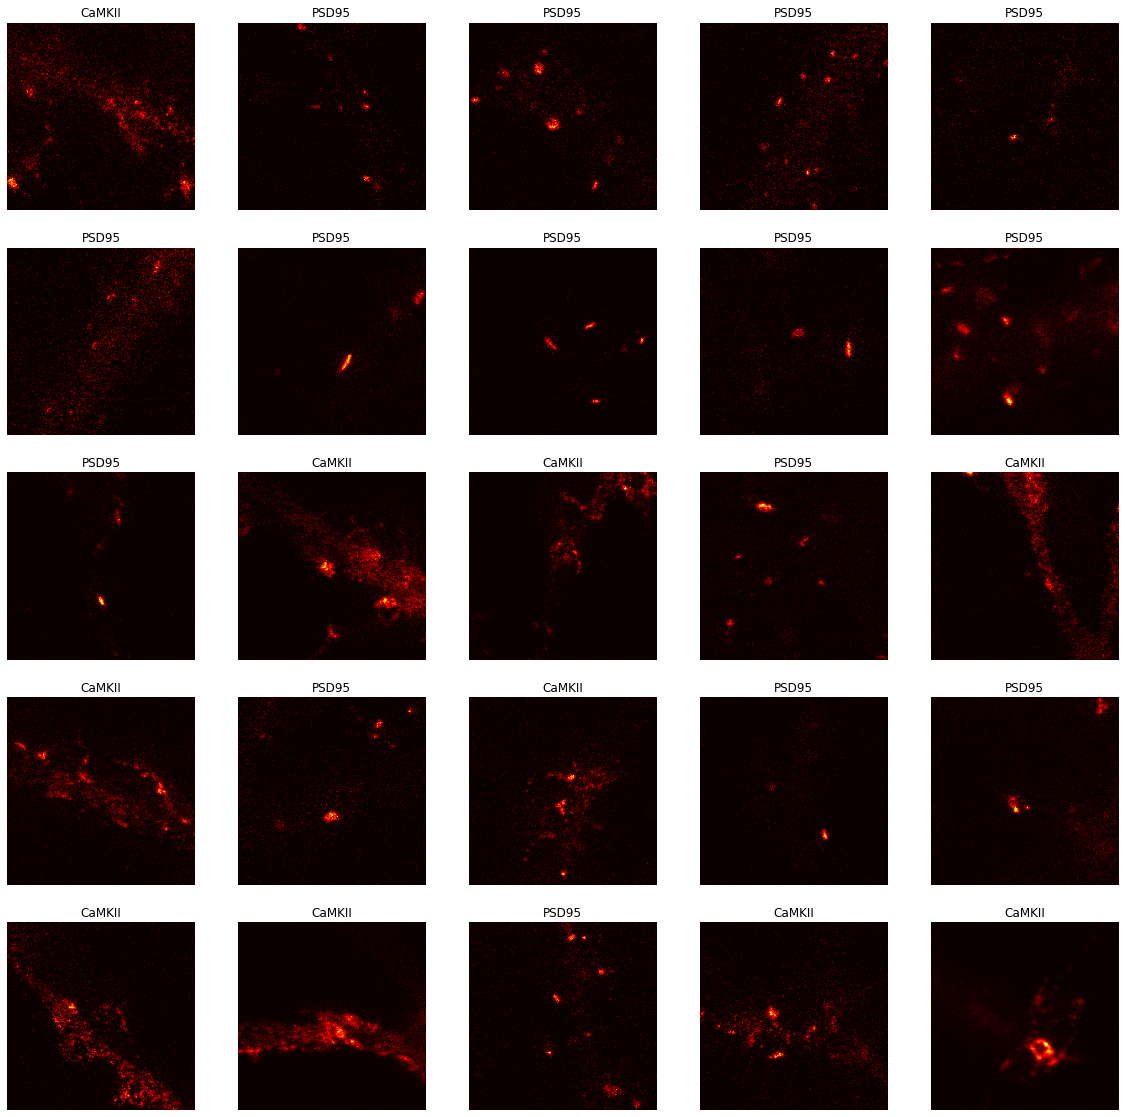

In [65]:
### Check why actin is getting split into two clusters 
print(np.unique(clusters1))
c1_indices = np.where(clusters1 == 1)[0]
c2_indices = np.where(clusters1 == 2)[0]
c1_indices = np.random.choice(c1_indices, size=25, replace=False)
c2_indices = np.random.choice(c2_indices, size=25, replace=False)

if N_CLASSES > 2:
    c3_indices = np.where(clusters1 == 3)[0]
    c4_indices = np.where(clusters1 == 4)[0]
    c3_indices = np.random.choice(c3_indices, size=25, replace=False)
    c4_indices = np.random.choice(c4_indices, size=25, replace=False)

fig, axs = plt.subplots(5, 5, figsize=(20,20))
for i, idx in enumerate(c1_indices):
    ax = axs.ravel()[i]
    d_idx = dataset_idx[idx]
    img = test_loader.dataset[d_idx][0]
    label = test_loader.dataset[d_idx][1]["label"]
    if DATASET == "neural-activity-states" and label.dtype == np.float32:
        label = label.astype(np.int32)
    img = img.squeeze().cpu().numpy()
    ax.imshow(img, cmap="hot")
    ax.axis("off")
    ax.set_title(CLASSES[label])
plt.show()


### Manual feature analysis

In [8]:
from skimage import measure 
from wavelet import detect_spots

c1_indices = np.where(clusters1 == 1)[0]
c2_indices = np.where(clusters1 == 2)[0]
c3_indices = np.where(clusters1 == 3)[0]
c4_indices = np.where(clusters1 == 4)[0]

manual_features = {
    key: [] * len(np.unique(labels)) for key in np.unique(clusters1)
}

for i, indices in enumerate([c1_indices, c2_indices, c3_indices, c4_indices]):
    for idx in indices:
        d_idx = dataset_idx[idx]
        img = test_loader.dataset[d_idx][0]
        label = test_loader.dataset[d_idx][1]["label"]
        if label.dtype == np.float32:
            label = label.astype(np.int32)
        img = img.squeeze().cpu().numpy()
        mask = detect_spots(img)
        mask_label, num_proteins = measure.label(mask, return_num=True)
        props = measure.regionprops(mask_label, intensity_image=img)
        areas, perimeters, eccentricities, mean_intensities, number_of_proteins = [], [], [], [], []
        for prop in props:
            areas.append(prop.area)
            perimeters.append(prop.perimeter)
            eccentricities.append(prop.eccentricity)
            mean_intensities.append(prop.mean_intensity)
        manual_features[i + 1].append([np.mean(areas), np.mean(perimeters), np.mean(eccentricities), np.mean(mean_intensities), num_proteins])
        

In [10]:

feature_names = ["Area", "Perimeter", "Eccentricity", "Mean Intensity", "# Proteins"]
xlims = [[50, 300], [30, 120], [0, 1], [0, 0.30], [0, 35]]
all_minimums, all_maximums = [], []
for i in range(np.array(manual_features[1]).shape[1]):
    feature_mins, features_maxs = [], []
    for key in manual_features.keys():
        features = np.array(manual_features[key])
        feature_mins.append(features[:, i].min())
        features_maxs.append(features[:, i].max())
    all_minimums.append(np.min(feature_mins))
    all_maximums.append(np.max(features_maxs))

[70.87878787878788, 29.438493615727744, 0.4099184053254105, 0.01908900775015354, 2.0] [347.8333333333333, 86.83554416128983, 0.9064731264941815, 0.2692311704158783, 33.0]


In [16]:
mean_array = np.zeros((len(manual_features.keys()), np.array(manual_features[1]).shape[1]))
for i in range(np.array(manual_features[1]).shape[1]):
    for key in manual_features.keys():
        features = np.array(manual_features[key])
        data = features[:, i]
        mean_feature = np.mean(data)
        mean_array[key - 1, i] = mean_feature

print(mean_array.shape, len(all_minimums), len(all_maximums))

(4, 5) 5 5


[70.87878787878788, 29.438493615727744, 0.4099184053254105, 0.01908900775015354, 2.0]
[347.8333333333333, 86.83554416128983, 0.9064731264941815, 0.2692311704158783, 33.0]
[[1.54904022e+02 5.01288212e+01 7.33903690e-01 1.41513976e-01
  1.86037736e+01]
 [1.09695296e+02 3.99782106e+01 6.52750018e-01 3.51141223e-02
  1.23170732e+01]
 [1.37860430e+02 4.70618472e+01 6.79463076e-01 1.15448324e-01
  1.36037736e+01]
 [1.55765337e+02 4.88316964e+01 7.05057062e-01 9.82356864e-02
  1.33743842e+01]]


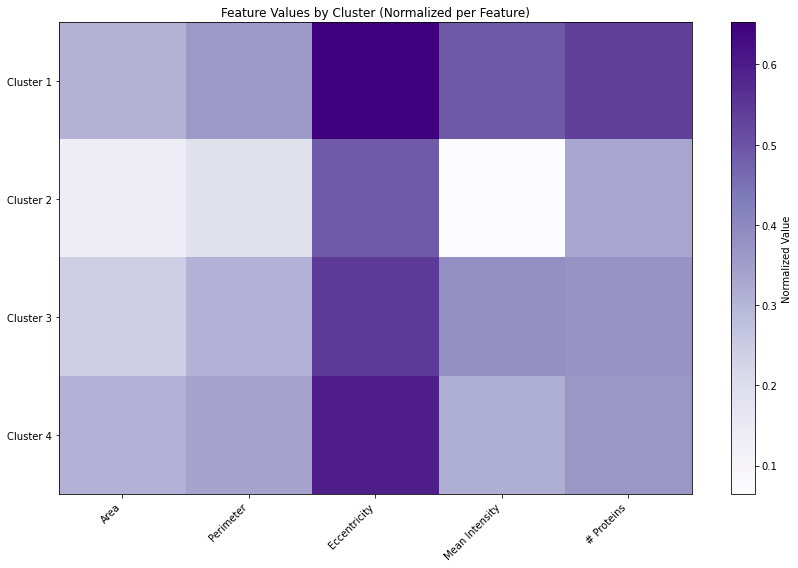

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

normalized_image = np.zeros_like(mean_array)
print(mean_array)
for i in range(mean_array.shape[1]):
    normalized_image[:, i] = (mean_array[:, i] - all_minimums[i]) / (all_maximums[i] - all_minimums[i])

im = ax.imshow(normalized_image, cmap='Purples', aspect='auto')
plt.colorbar(im, label='Normalized Value')

ax.set_xticks(np.arange(len(feature_names)))
ax.set_yticks(np.arange(len(manual_features.keys())))
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_yticklabels([f'Cluster {i+1}' for i in range(len(manual_features.keys()))])

plt.title('Feature Values by Cluster (Normalized per Feature)')
plt.tight_layout()
plt.show()